# Testing CAMB-Multifluid
Author: João Victor S. Rebouças, January 2022.

This is a notebook for testing our CAMB modification for multiple fluids. Download the modified CAMB version at https://github.com/CoupleDE-UNESP/CAMB-EDE

In [1]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os, sys
import camb

# If you have many CAMB versions at your disposal, it's always useful to check which CAMB is being used.
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

# Matplotlib settings - Plots in Latex font
axislabelfontsize='large'
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [10.0,7.5]
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 16,
})
axislabelfontsize='large'

Using CAMB 1.3.5 installed at /home/joaov/cosmo/CAMB/CAMBMultiFluidDE/camb


In [2]:
# Energy density unit conversion
Mpc = 3.085678e22
c = 2.99792458e8
G = 6.6738e-11
kappa = 8 * np.pi * G
hplanck = 6.62606896e-34
hbar = hplanck/2/np.pi
Tpl = np.sqrt(kappa*hbar/c**5)
energyunitconversion = Mpc**2/(c**2 * Tpl**2)

## $\Lambda$CDM
Since I changed the dark energy interface as a whole, it's important to check if $\Lambda$CDM is still working properly. I compare the $\Lambda$CDM power spectra between the original CAMB and this modification.

In [4]:
lcdmcosmology = camb.set_params(# Background
                                H0 = 70, ombh2=0.02238280, omch2=0.1201075, TCMB = 2.7255,
                                # Neutrinos
                                omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                                nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                                # Initial Power Spectrum
                                As = 2.100549e-09, ns = 0.9660499, 
                                YHe = 0.246, WantTransfer=True)
lcdmresults = camb.get_results(lcdmcosmology)
lcdmcls = lcdmresults.get_unlensed_scalar_cls(CMB_unit = 'muK')[:,0]
ells = [i for i in range(len(lcdmcls))]
ks = lcdmresults.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[0]
lcdmpks = lcdmresults.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[2]
scales = np.logspace(-6, 0)
rho, w = lcdmresults.get_dark_energy_rho_w(scales)
omega = lcdmresults.get_Omega('de', z = 1/scales - 1)

In [5]:
print(lcdmresults.get_derived_params())

{'age': 13.579046034471643, 'zstar': 1089.9280058199213, 'rstar': 144.41117783609766, 'thetastar': 1.0475519038978673, 'DAstar': 13.785586881065633, 'zdrag': 1059.987219381464, 'rdrag': 147.06680783028986, 'kd': 0.14088098407990415, 'thetad': 0.1617604090414109, 'zeq': 3405.995492849275, 'keq': 0.01039376096786709, 'thetaeq': 0.8176573097998605, 'thetarseq': 0.4518185995718867}


In [4]:
# Reading output from original CAMB
original_cls = []
original_pks = []
with open('cls.dat', 'r') as f:
    for line in f.readlines():
        try:
            original_cls.append(float(line.split()[1]))
        except ValueError:
            pass
with open('pks.dat', 'r') as f:
    for line in f.readlines():
        try:
            original_pks.append(float(line.split()[1]))
        except ValueError:
            pass

FileNotFoundError: [Errno 2] No such file or directory: 'cls.dat'

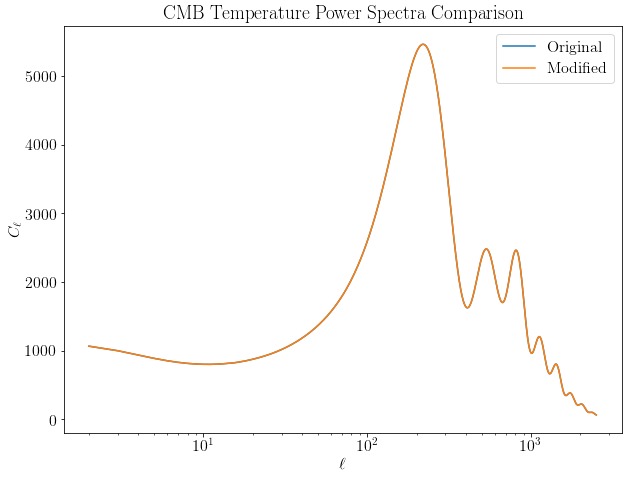

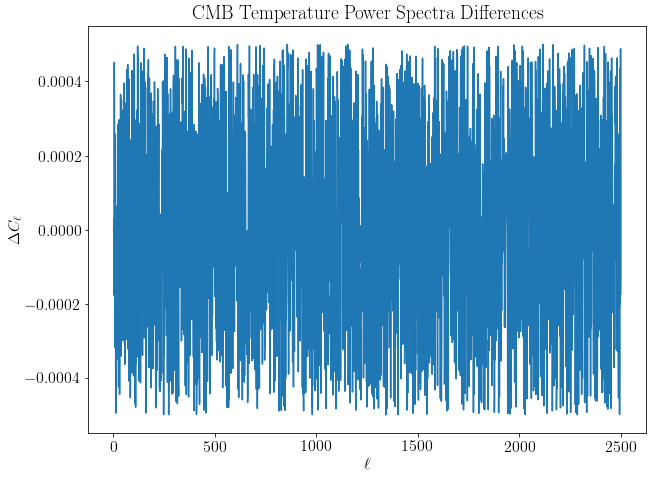

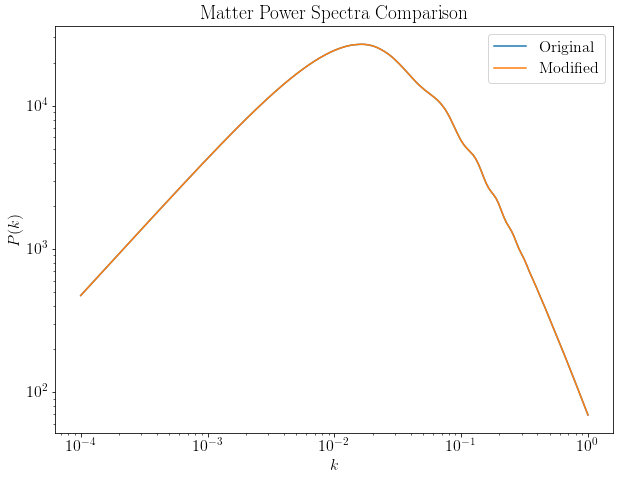

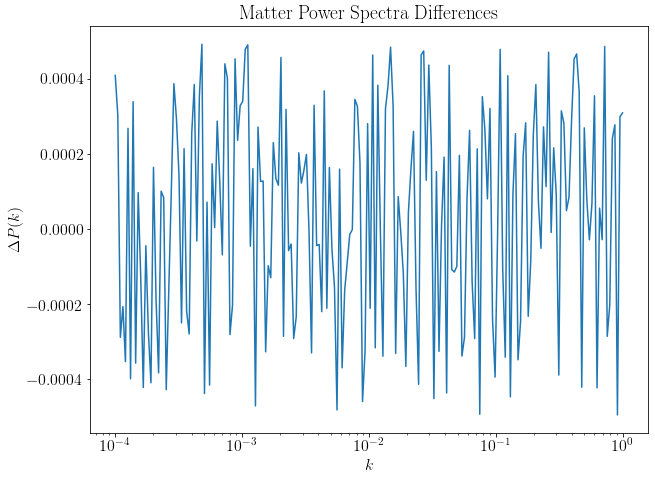

In [5]:
# Comparing Cls and Pk between original CAMB and our modification
# Cl_TT
ells = [i for i in range(len(lcdmcls))]
plt.plot(ells[2:], original_cls[2:])
plt.plot(ells[2:], lcdmcls[2:])
plt.xscale('log')
plt.title("CMB Temperature Power Spectra Comparison")
plt.legend(["Original", "Modified"])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.show()
# Cl_TT differences
plt.plot(lcdmcls - original_cls)
plt.title("CMB Temperature Power Spectra Differences")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\Delta C_\ell$")
plt.show()
# Matter power spectrum P(k)
plt.plot(ks, original_pks)
plt.plot(ks, lcdmpks[0])
plt.title("Matter Power Spectra Comparison")
plt.legend(["Original", "Modified"])
plt.xlabel(r"$k$")
plt.ylabel(r"$P(k)$")
plt.xscale('log')
plt.yscale('log')
plt.show()
# Matter power spectrum differences
plt.plot(ks, original_pks-lcdmpks[0])
plt.title("Matter Power Spectra Differences")
plt.xlabel(r"$k$")
plt.ylabel(r"$\Delta P(k)$")
plt.xscale('log')
plt.show()

The results are great! The differences are indeed negligible and seem to arise from numerical precision, since there are no biases. The interface redesign seems to be working for the models already implemented.

## Testing the Multifluid model
As for now, we only have two models: w constant and EDE Effective Fluid. Let's run the model.

In [1]:
# Choosing an example cosmology
# The only change is in the dark energy model
# There are two dark energy components:
# One with constant w = -0.9,
# Other Early Dark Energy component with zc = 4000, fde = 0.1, wn = 1
multifluidcosmology = camb.set_params(# Background
                                H0 = 70, ombh2=0.02238280, omch2=0.1201075, TCMB = 2.7255,
                                # Dark Energy Model
                                dark_energy_model = 'MultiFluidDE',
                                num_of_components = 2, models = [1,1,0,0],
                                w0 = -0.9, wa = 0, zc = 4000, fde_zc = 0.1, wn = 1,
                                # Initial Power Spectrum
                                As = 2.100549e-09, ns = 0.9660499, 
                                YHe = 0.246, WantTransfer=True)
multifluidresults = camb.get_results(multifluidcosmology)
multifluidcls = multifluidresults.get_unlensed_scalar_cls(CMB_unit = 'muK')[:,0]
ks = multifluidresults.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[0]
multifluidpks = multifluidresults.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[2]
scales = np.logspace(-6, 0, 200)
rho, w = multifluidresults.get_dark_energy_rho_w(scales)
omega = multifluidresults.get_Omega('de', z = 1/scales - 1)
omegaede = multifluidresults.get_Omega('de2', z = 1/scales - 1)

NameError: name 'camb' is not defined

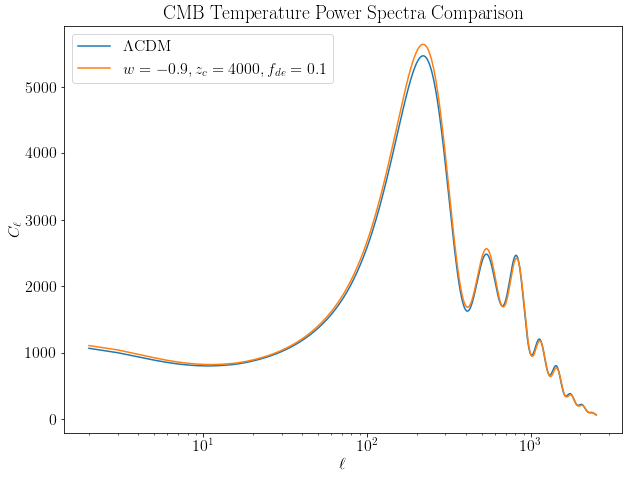

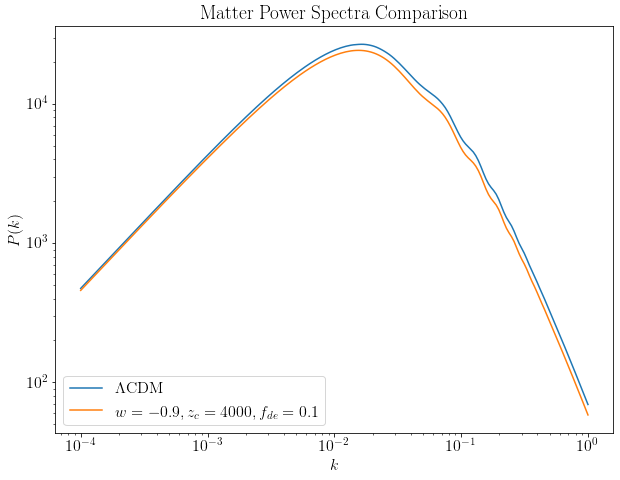

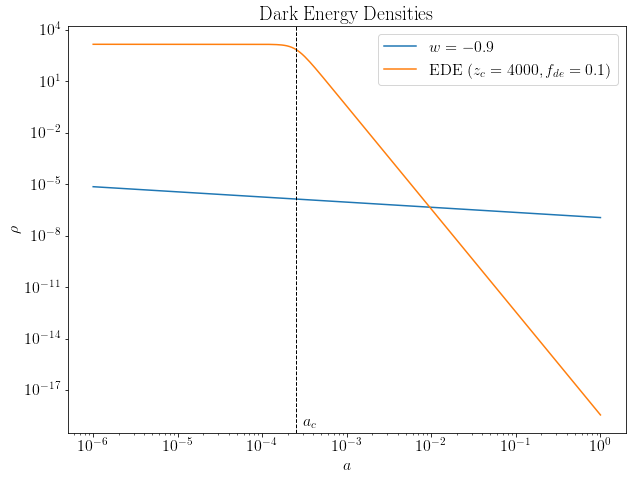

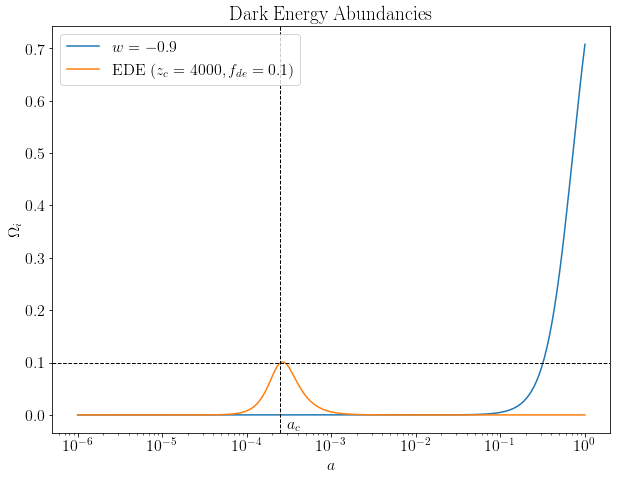

In [14]:
# Some plots
# Comparing this cosmology and LambdaCDM
plt.plot(ells[2:], lcdmcls[2:])
plt.plot(ells[2:], multifluidcls[2:])
plt.title("CMB Temperature Power Spectra Comparison")
plt.legend([r"$\Lambda$CDM", r"$w = -0.9, z_c = 4000, f_{de} = 0.1$"])
plt.xscale('log')
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.show()
# Matter power spectrum P(k)
plt.plot(ks, lcdmpks[0])
plt.plot(ks, multifluidpks[0])
plt.title("Matter Power Spectra Comparison")
plt.legend([r"$\Lambda$CDM", r"$w = -0.9, z_c = 4000, f_{de} = 0.1$"])
plt.xlabel(r"$k$")
plt.ylabel(r"$P(k)$")
plt.xscale('log')
plt.yscale('log')
plt.show()
# Dark energy densities
plt.plot(scales, rho[:,0])
plt.plot(scales, rho[:,1])
plt.axvline(1/(4000+1), c='black', linestyle='dashed', linewidth=1)
plt.text(1/(4000+1)+0.00005,10**-19,r'$a_c$')
plt.title("Dark Energy Densities")
plt.legend([r"$w = -0.9$", r"EDE $(z_c = 4000, f_{de} = 0.1)$"])
plt.xscale('log')
plt.xlabel(r"$a$")
plt.ylabel(r"$\rho$")
plt.xscale('log')
plt.yscale('log')
plt.show()
# Dark energy abundancies
plt.plot(scales, omega)
plt.plot(scales, omegaede)
plt.axvline(1/(4000+1), c='black', linestyle='dashed', linewidth=1)
plt.axhline(0.1, c='black', linestyle='dashed', linewidth=1)
plt.text(1/(4000+1)+0.00005,-0.025,r'$a_c$')
plt.title("Dark Energy Abundancies")
plt.legend([r"$w = -0.9$", r"EDE $(z_c = 4000, f_{de} = 0.1)$"])
plt.xscale('log')
plt.xlabel(r"$a$")
plt.ylabel(r"$\Omega_i$")
plt.xscale('log')
plt.show()

## Testing w constant fluid,  no EDE
Here, I want to check if w constant matches with the original CAMB.

In [11]:
ws = [-0.8]
scales = np.logspace(-6, 0, 100)
redshifts = np.logspace(0, 5, 500)
k = 0.3
for w in ws:
    cosmology1 = camb.set_params(# Background
                                    H0 = 70, ombh2=0.02238280, omch2=0.1201075, TCMB = 2.7255,
                                    dark_energy_model = 'fluid', w = w,
                                    # Neutrinos
                                    omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                                    nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                                    # Initial Power Spectrum
                                    As = 2.100549e-09, ns = 0.9660499, 
                                    YHe = 0.246, WantTransfer=True)
    cosmology2 = camb.set_params(# Background
                                    H0 = 70, ombh2=0.02238280, omch2=0.1201075, TCMB = 2.7255,
                                    dark_energy_model = 'MultiFluidDE',
                                    num_of_components = 1, models = [1,1,0,0],
                                    w0 = w, wa = 0, zc = 1000, fde_zc = 0, wn = 1,
                                    # Neutrinos
                                    omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                                    nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                                    # Initial Power Spectrum
                                    As = 2.100549e-09, ns = 0.9660499, 
                                    YHe = 0.246, WantTransfer=True)
    results1 = camb.get_results(cosmology1)
    results2 = camb.get_results(cosmology2)
    rho_de = results1.get_background_densities(scales)['de']
    rho_de2 = results2.get_background_densities(scales)['de']
    rho1, _= results1.get_dark_energy_rho_w(scales)
    rho2, _= results2.get_dark_energy_rho_w(scales)
    cls = results1.get_unlensed_scalar_cls(CMB_unit = 'muK')[:,0]
    cls2 = results2.get_unlensed_scalar_cls(CMB_unit = 'muK')[:,0]
    delta_de_1 = results1.get_redshift_evolution(k, redshifts, 'delta_tot_de')
    delta_de_2 = results2.get_redshift_evolution(k, redshifts, 'delta_tot_de')
    delta_ph_1 = results1.get_redshift_evolution(k, redshifts, 'delta_photon')
    delta_ph_2 = results2.get_redshift_evolution(k, redshifts, 'delta_photon')
    v_ph_1 = results1.get_redshift_evolution(k, redshifts, 'v_photon')
    v_ph_2 = results2.get_redshift_evolution(k, redshifts, 'v_photon')
    pi_ph_1 = results1.get_redshift_evolution(k, redshifts, 'pi_photon')
    pi_ph_2 = results2.get_redshift_evolution(k, redshifts, 'pi_photon')
    H1 = results1.get_redshift_evolution(k, redshifts, 'H')
    H2 = results2.get_redshift_evolution(k, redshifts, 'H')
    etak1 = results1.get_redshift_evolution(k, redshifts, 'etak')
    etak2 = results2.get_redshift_evolution(k, redshifts, 'etak')
    g1 = results1.get_redshift_evolution(k, redshifts, 'growth')
    g2 = results2.get_redshift_evolution(k, redshifts, 'growth')

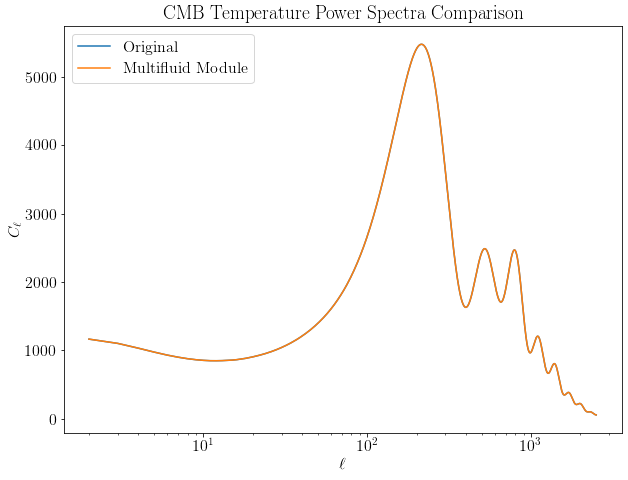

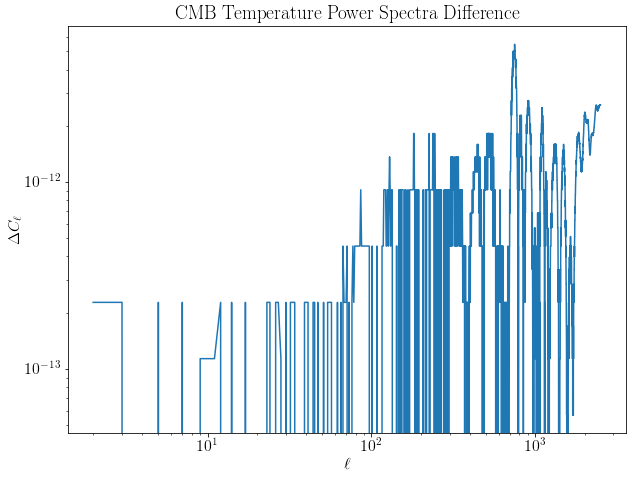

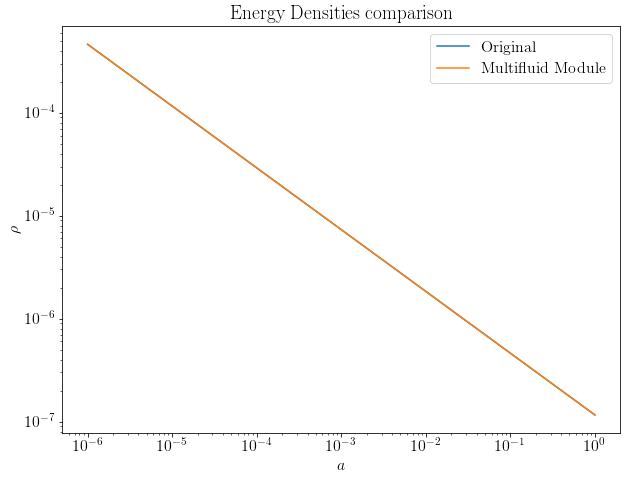

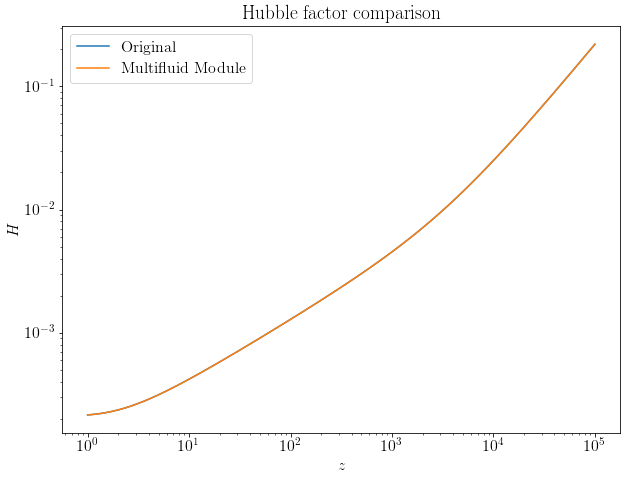

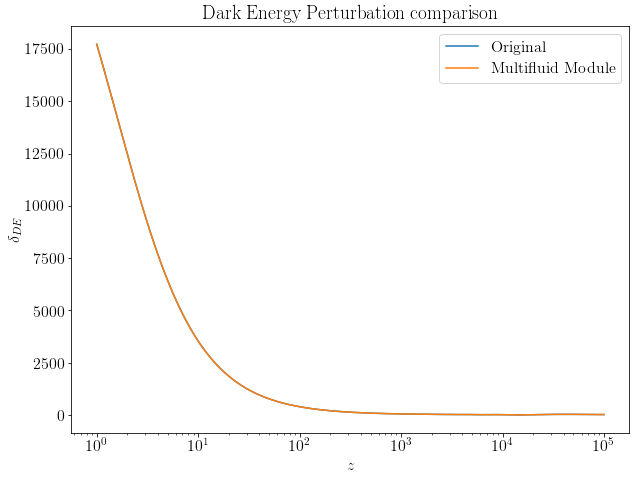

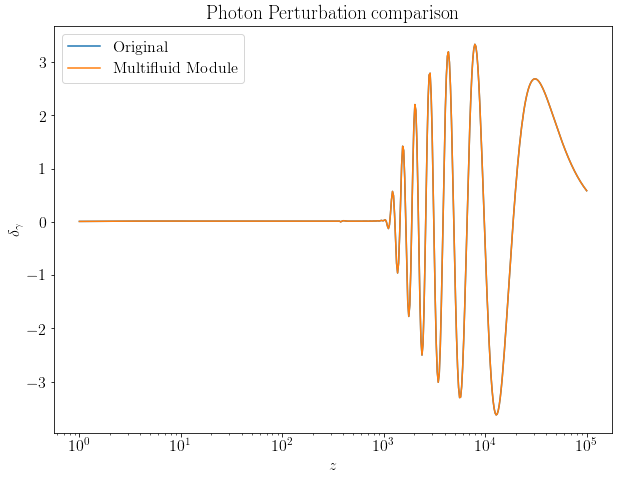

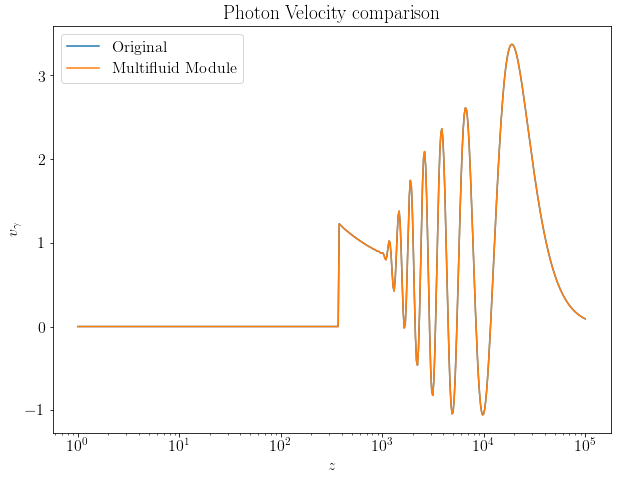

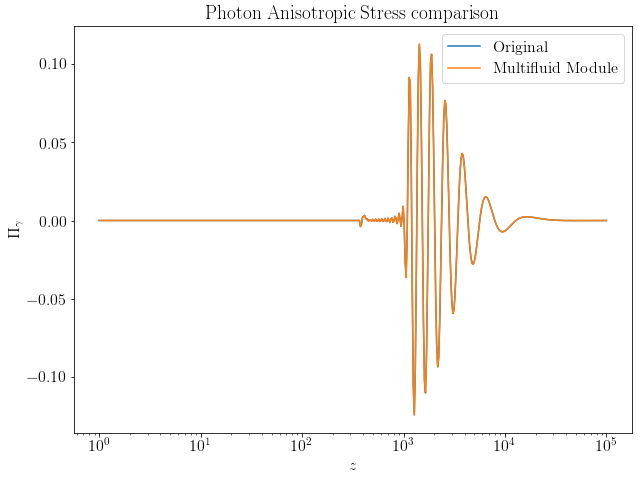

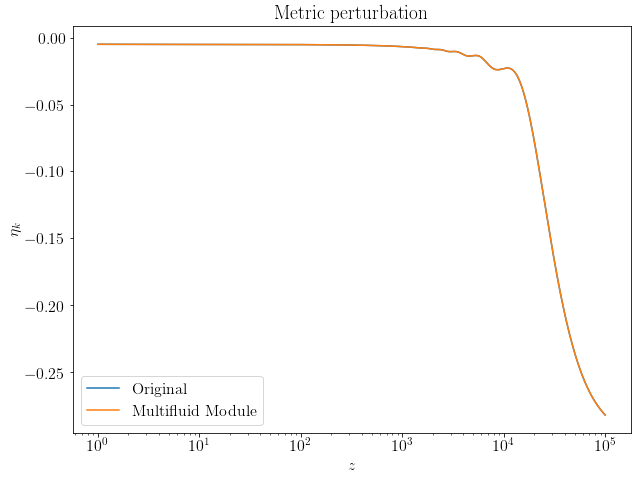

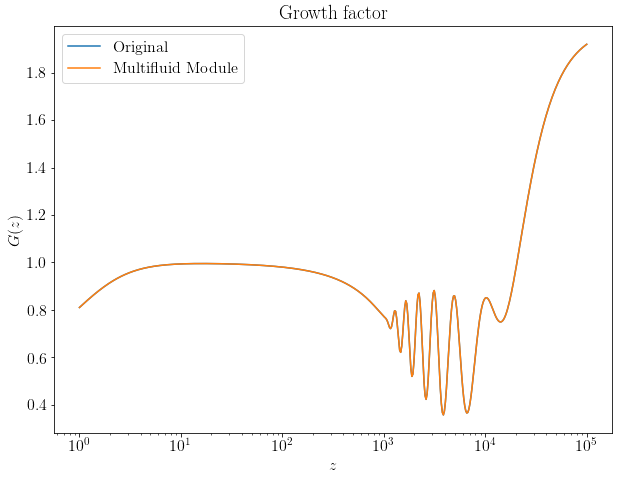

In [12]:
# Cls from CMB
plt.plot(ells[2:], cls[2:])
plt.plot(ells[2:], cls2[2:])
plt.title("CMB Temperature Power Spectra Comparison")
plt.legend([r"Original", r"Multifluid Module"])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.xscale('log')
plt.show()
# Cls diff
plt.plot(ells[2:], abs(cls[2:] - cls2[2:]))
plt.title("CMB Temperature Power Spectra Difference")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\Delta C_\ell$")
plt.yscale('log')
plt.xscale('log')
plt.show()
# DE densities
plt.plot(scales, rho_de/scales**4)
plt.plot(scales, rho_de2/scales**4)
plt.title("Energy Densities comparison")
plt.legend([r"Original", r"Multifluid Module"])
plt.xlabel(r"$a$")
plt.ylabel(r"$\rho$")
plt.xscale('log')
plt.yscale('log')
plt.show()
# Hubble factor
plt.plot(redshifts, H1[:,0])
plt.plot(redshifts, H2[:,0])
plt.title("Hubble factor comparison")
plt.legend([r"Original", r"Multifluid Module"])
plt.xlabel(r"$z$")
plt.ylabel(r"$H$")
plt.xscale('log')
plt.yscale('log')
plt.show()
# DE perturbation contrast
plt.plot(redshifts, delta_de_1)
plt.plot(redshifts, delta_de_2)
plt.title("Dark Energy Perturbation comparison")
plt.legend([r"Original", r"Multifluid Module"])
plt.xlabel(r"$z$")
plt.ylabel(r"$\delta_{DE}$")
plt.xscale('log')
plt.show()
# Photon perturbation contrast
plt.plot(redshifts, delta_ph_1)
plt.plot(redshifts, delta_ph_2)
plt.title("Photon Perturbation comparison")
plt.legend([r"Original", r"Multifluid Module"])
plt.xlabel(r"$z$")
plt.ylabel(r"$\delta_{\gamma}$")
plt.xscale('log')
plt.show()
# Photon bulk velocity
plt.plot(redshifts, v_ph_1)
plt.plot(redshifts, v_ph_2)
plt.title("Photon Velocity comparison")
plt.legend([r"Original", r"Multifluid Module"])
plt.xlabel(r"$z$")
plt.ylabel(r"$v_{\gamma}$")
plt.xscale('log')
plt.show()
# Photon anisotropic stress
plt.plot(redshifts, pi_ph_1)
plt.plot(redshifts, pi_ph_2)
plt.title("Photon Anisotropic Stress comparison")
plt.legend([r"Original", r"Multifluid Module"])
plt.xlabel(r"$z$")
plt.ylabel(r"$\Pi_{\gamma}$")
plt.xscale('log')
plt.show()
# Etak
plt.plot(redshifts, etak1)
plt.plot(redshifts, etak2)
plt.title("Metric perturbation")
plt.legend([r"Original", r"Multifluid Module"])
plt.xlabel(r"$z$")
plt.ylabel(r"$\eta_k$")
plt.xscale('log')
plt.show()
# Growth factor
plt.plot(redshifts, g1)
plt.plot(redshifts, g2)
plt.title("Growth factor")
plt.legend([r"Original", r"Multifluid Module"])
plt.xlabel(r"$z$")
plt.ylabel(r"$G(z)$")
plt.xscale('log')
plt.show()

In [13]:
# Differences in derived parameters
for element in results1.get_derived_params():
    print(element, results1.get_derived_params()[element] - results2.get_derived_params()[element])

age 0.0
zstar 0.0
rstar 0.0
thetastar 0.0
DAstar 0.0
zdrag 0.0
rdrag 0.0
kd 0.0
thetad 0.0
zeq 0.0
keq 0.0
thetaeq 0.0
thetarseq 0.0


## Comparing the EDE part
Just to make sure the fluid equations are correct, I compare a cosmology with EDE effective fluid + a cosmological constant between this modification and the original CAMB.

In [11]:
# Cls from original CAMB using AxionEffectiveFluid
edeoriginalcls = np.genfromtxt('ededata.txt', unpack=True)

In [14]:
# Varying the peak redshift
zc_targets = [4000]
scales = np.logspace(-6, 0, 100)
fde_zc = 0.05
for zc_target in zc_targets:
    edecosmology1 = camb.set_params(# Background
                                    H0 = 70, ombh2=0.02238280, omch2=0.1201075, TCMB = 2.7255,
                                    # Early Dark Energy with Rock 'n' Roll
                                    dark_energy_model = 'AxionEffectiveFluid',
                                    zc = zc_target, fde_zc = fde_zc, w_n = 1,
                                    # Neutrinos
                                    omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                                    nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                                    # Initial Power Spectrum
                                    As = 2.100549e-09, ns = 0.9660499, 
                                    YHe = 0.246, WantTransfer=True)
    edecosmology2 = camb.set_params(# Background
                                    H0 = 70, ombh2=0.02238280, omch2=0.1201075, TCMB = 2.7255,
                                    # Early Dark Energy with Rock 'n' Roll
                                    dark_energy_model = 'MultiFluidDE', num_of_components = 2,
                                    models = [1,1,0,0], w0 = -1, wa = 0,
                                    zc = zc_target, fde_zc = fde_zc, wn = 1,
                                    # Neutrinos
                                    omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                                    nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                                    # Initial Power Spectrum
                                    As = 2.100549e-09, ns = 0.9660499, 
                                    YHe = 0.246, WantTransfer=True)
    ederesults1 = camb.get_results(edecosmology1)
    ederesults2 = camb.get_results(edecosmology2)
    rhode1 = ederesults1.get_background_densities(scales)['de']
    rhode2 = ederesults2.get_background_densities(scales)['de'] + ederesults2.get_background_densities(scales)['de2']
    _, w_de = ederesults1.get_dark_energy_rho_w(scales)
    _, w_de2 = ederesults2.get_dark_energy_rho_w(scales)
    cls = ederesults1.get_unlensed_scalar_cls(CMB_unit = 'muK')[:,0]
    cls2 = ederesults2.get_unlensed_scalar_cls(CMB_unit = 'muK')[:,0]
    omegalambda = ederesults2.get_Omega('de', z = 1/scales - 1)
    omegaede = ederesults2.get_Omega('de2', z = 1/scales - 1)

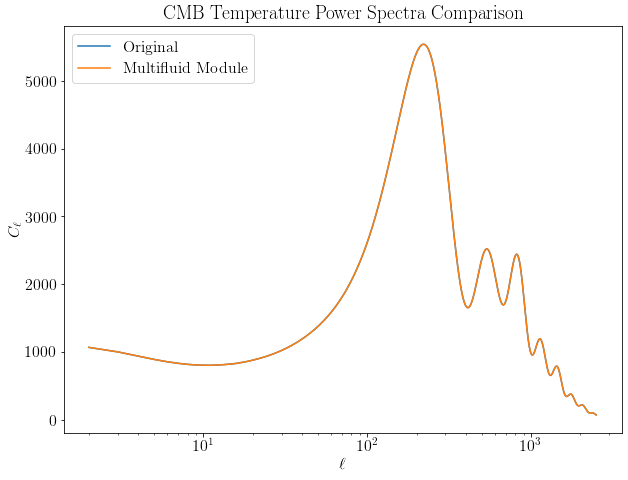

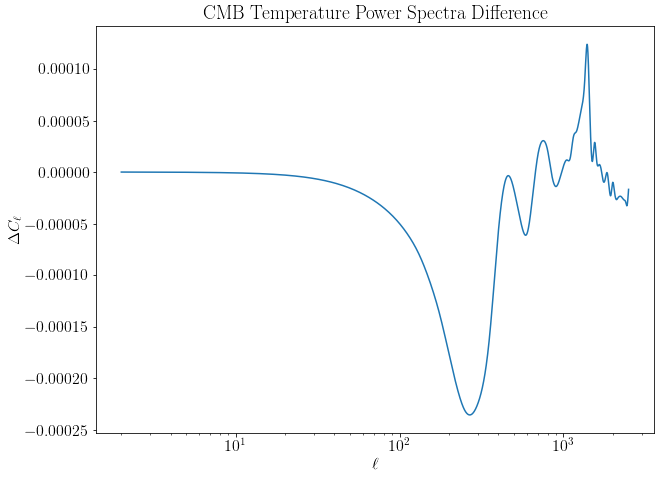

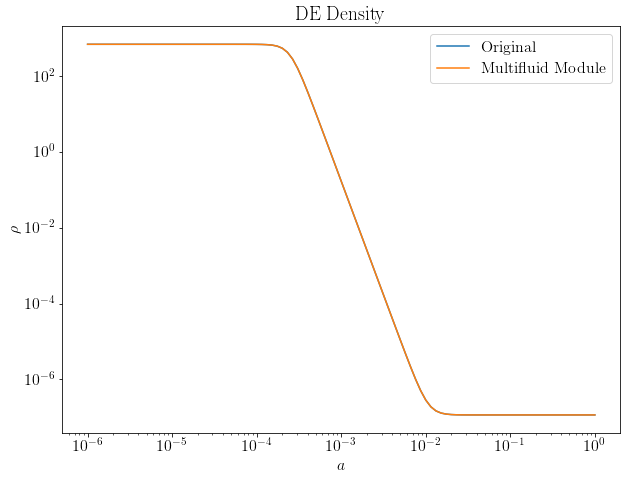

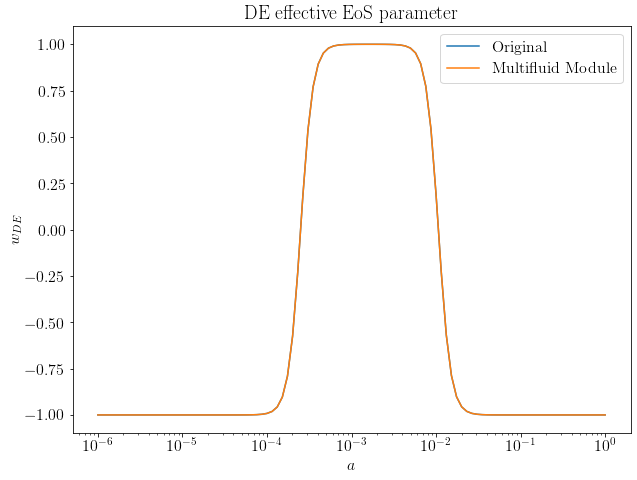

In [15]:
effective_de_w = (omegalambda * w_de2[:,0] + omegaede * w_de2[:,1])/(omegalambda + omegaede)
# Cls plot
plt.plot(ells[2:], cls[2:])
plt.plot(ells[2:], cls2[2:])
plt.title("CMB Temperature Power Spectra Comparison")
plt.legend([r"Original", r"Multifluid Module"])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.xscale('log')
plt.show()
# Cls difference
plt.plot(ells[2:], cls[2:] - cls2[2:])
plt.title("CMB Temperature Power Spectra Difference")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\Delta C_\ell$")
plt.xscale('log')
plt.show()
# DE densities
plt.plot(scales, rhode1/scales**4)
plt.plot(scales, rhode2/scales**4)
plt.title("DE Density")
plt.legend([r"Original", r"Multifluid Module"])
plt.xlabel(r"$a$")
plt.ylabel(r"$\rho$")
plt.xscale('log')
plt.yscale('log')
plt.show()
# DE effective EoS parameter
plt.plot(scales, w_de[:, 0])
plt.plot(scales, effective_de_w)
plt.title("DE effective EoS parameter")
plt.legend([r"Original", r"Multifluid Module"])
plt.xlabel(r"$a$")
plt.ylabel(r"$w_{DE}$")
plt.xscale('log')
plt.show()

## Comparing PPF

In [16]:
ws = [-0.8]
scales = np.logspace(-6, 0, 100)
redshifts = np.logspace(0, 5, 500)
k = 0.3
for w in ws:
    cosmology1 = camb.set_params(# Background
                                    H0 = 70, ombh2=0.02238280, omch2=0.1201075, TCMB = 2.7255,
                                    dark_energy_model = 'ppf', w = w, wa = -0.4,
                                    # Neutrinos
                                    omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                                    nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                                    # Initial Power Spectrum
                                    As = 2.100549e-09, ns = 0.9660499, 
                                    YHe = 0.246, WantTransfer=True)
    cosmology2 = camb.set_params(# Background
                                    H0 = 70, ombh2=0.02238280, omch2=0.1201075, TCMB = 2.7255,
                                    dark_energy_model = 'MultiFluidDE',
                                    num_of_components = 1, models = [2,1,0,0],
                                    w0 = w, wa = -0.4, zc = 1000, fde_zc = 0, wn = 1,
                                    # Neutrinos
                                    omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                                    nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                                    # Initial Power Spectrum
                                    As = 2.100549e-09, ns = 0.9660499, 
                                    YHe = 0.246, WantTransfer=True)
    results1 = camb.get_results(cosmology1)
    results2 = camb.get_results(cosmology2)
    rho_de = results1.get_background_densities(scales)['de']
    rho_de2 = results2.get_background_densities(scales)['de']
    _, wde1= results1.get_dark_energy_rho_w(scales)
    _, wde2= results2.get_dark_energy_rho_w(scales)
    cls = results1.get_unlensed_scalar_cls(CMB_unit = 'muK')[:,0]
    cls2 = results2.get_unlensed_scalar_cls(CMB_unit = 'muK')[:,0]
    delta_de_1 = results1.get_redshift_evolution(k, redshifts, 'delta_tot_de')
    delta_de_2 = results2.get_redshift_evolution(k, redshifts, 'delta_tot_de')
    delta_ph_1 = results1.get_redshift_evolution(k, redshifts, 'delta_photon')
    delta_ph_2 = results2.get_redshift_evolution(k, redshifts, 'delta_photon')
    v_ph_1 = results1.get_redshift_evolution(k, redshifts, 'v_photon')
    v_ph_2 = results2.get_redshift_evolution(k, redshifts, 'v_photon')
    pi_ph_1 = results1.get_redshift_evolution(k, redshifts, 'pi_photon')
    pi_ph_2 = results2.get_redshift_evolution(k, redshifts, 'pi_photon')
    H1 = results1.get_redshift_evolution(k, redshifts, 'H')
    H2 = results2.get_redshift_evolution(k, redshifts, 'H')
    etak1 = results1.get_redshift_evolution(k, redshifts, 'etak')
    etak2 = results2.get_redshift_evolution(k, redshifts, 'etak')
    g1 = results1.get_redshift_evolution(k, redshifts, 'growth')
    g2 = results2.get_redshift_evolution(k, redshifts, 'growth')

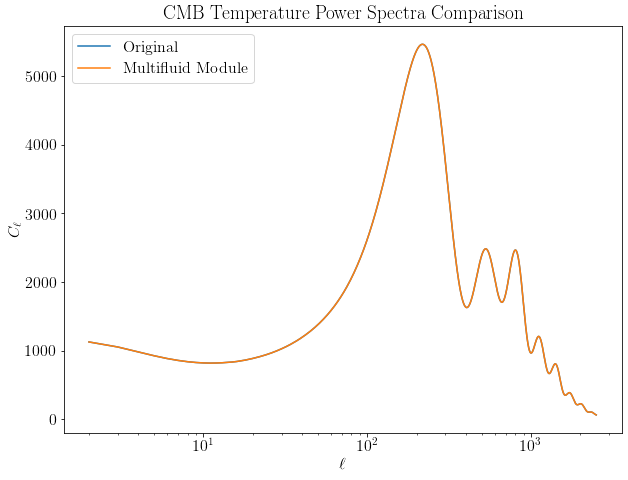

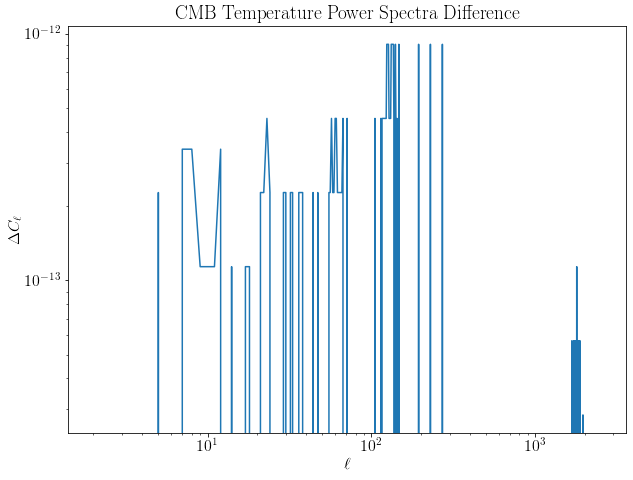

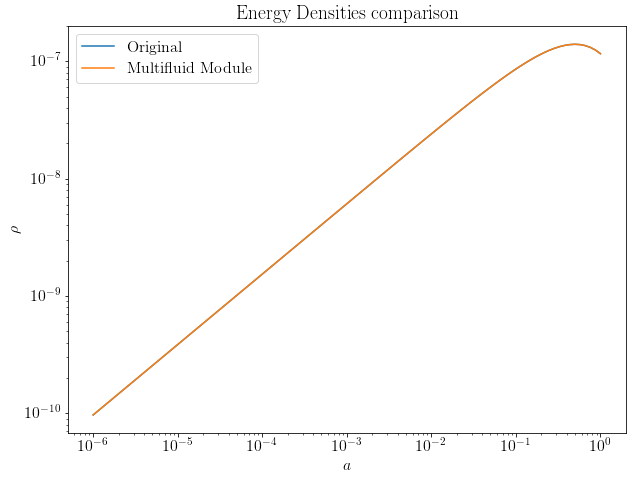

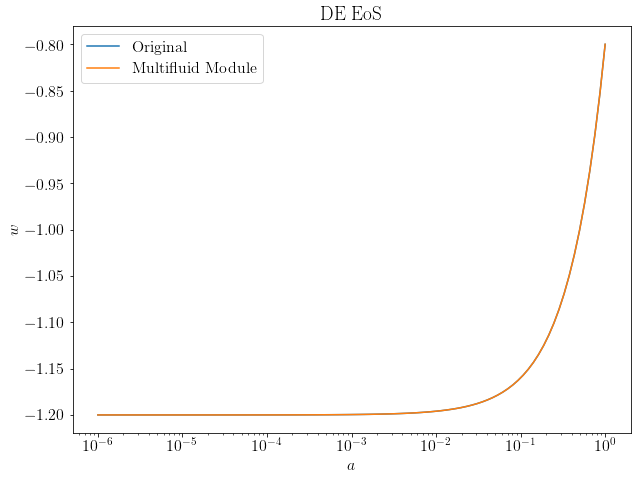

In [17]:
# Cls from CMB
plt.plot(ells[2:], cls[2:])
plt.plot(ells[2:], cls2[2:])
plt.title("CMB Temperature Power Spectra Comparison")
plt.legend([r"Original", r"Multifluid Module"])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.xscale('log')
plt.show()
# Cls diff
plt.plot(ells[2:], abs(cls[2:] - cls2[2:]))
plt.title("CMB Temperature Power Spectra Difference")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\Delta C_\ell$")
plt.yscale('log')
plt.xscale('log')
plt.show()
# DE densities
plt.plot(scales, rho_de/scales**4)
plt.plot(scales, rho_de2/scales**4)
plt.title("Energy Densities comparison")
plt.legend([r"Original", r"Multifluid Module"])
plt.xlabel(r"$a$")
plt.ylabel(r"$\rho$")
plt.xscale('log')
plt.yscale('log')
plt.show()
# DE EoS
plt.plot(scales, wde1[:,0])
plt.plot(scales, wde2[:,0])
plt.title("DE EoS")
plt.legend([r"Original", r"Multifluid Module"])
plt.xlabel(r"$a$")
plt.ylabel(r"$w$")
plt.xscale('log')
plt.show()

## Testing EDE with w0wa
To test the PPF implementation with EDE, I compare the different models with wa = 0.

In [18]:
ws = [-0.8]
scales = np.logspace(-6, 0, 100)
redshifts = np.logspace(0, 5, 500)
k = 0.3
wa = -0.3
for w in ws:
    cosmology1 = camb.set_params(# Background
                                    H0 = 70, ombh2=0.02238280, omch2=0.1201075, TCMB = 2.7255,
                                    dark_energy_model = 'MultiFluidDE', num_of_components = 2, models = [1,1,0,0],
                                    w0 = w, wa = 0, zc = 4000, fde_zc = 0.1, wn = 1,
                                    # Neutrinos
                                    omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                                    nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                                    # Initial Power Spectrum
                                    As = 2.100549e-09, ns = 0.9660499, 
                                    YHe = 0.246, WantTransfer=True)
    cosmology2 = camb.set_params(# Background
                                    H0 = 70, ombh2=0.02238280, omch2=0.1201075, TCMB = 2.7255,
                                    dark_energy_model = 'MultiFluidDE',
                                    num_of_components = 2, models = [2,1,0,0],
                                    w0 = w, wa = 0, zc = 4000, fde_zc = 0.1, wn = 1,
                                    # Neutrinos
                                    omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                                    nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                                    # Initial Power Spectrum
                                    As = 2.100549e-09, ns = 0.9660499, 
                                    YHe = 0.246, WantTransfer=True)
    results1 = camb.get_results(cosmology1)
    results2 = camb.get_results(cosmology2)
    rho_de = results1.get_background_densities(scales)['de']
    rho_de2 = results2.get_background_densities(scales)['de']
    rho_ede2 = results2.get_background_densities(scales)['de2']
    _, wde1= results1.get_dark_energy_rho_w(scales)
    _, wde2= results2.get_dark_energy_rho_w(scales)
    cls = results1.get_unlensed_scalar_cls(CMB_unit = 'muK')[:,0]
    cls2 = results2.get_unlensed_scalar_cls(CMB_unit = 'muK')[:,0]
    omegaw1 = results1.get_Omega('de', z = 1/scales - 1)
    omegaw2 = results2.get_Omega('de', z = 1/scales - 1)
    omegaede = results2.get_Omega('de2', z = 1/scales - 1)

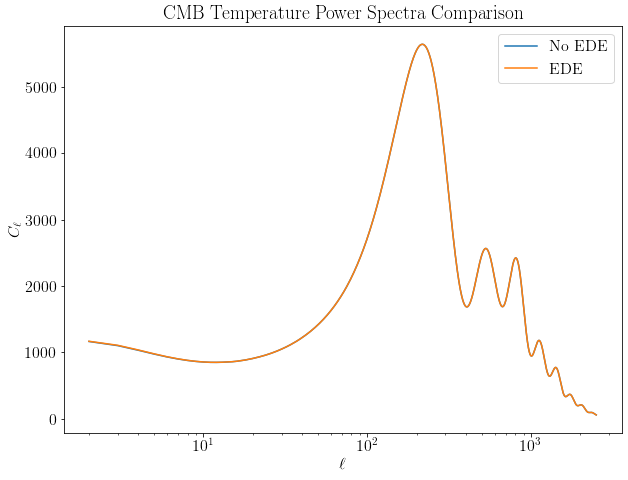

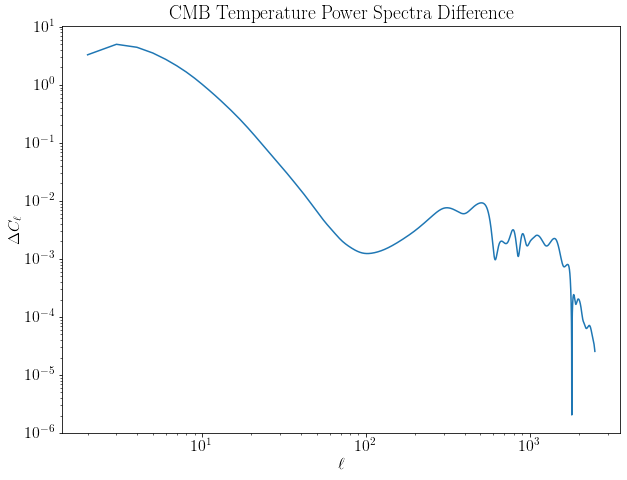

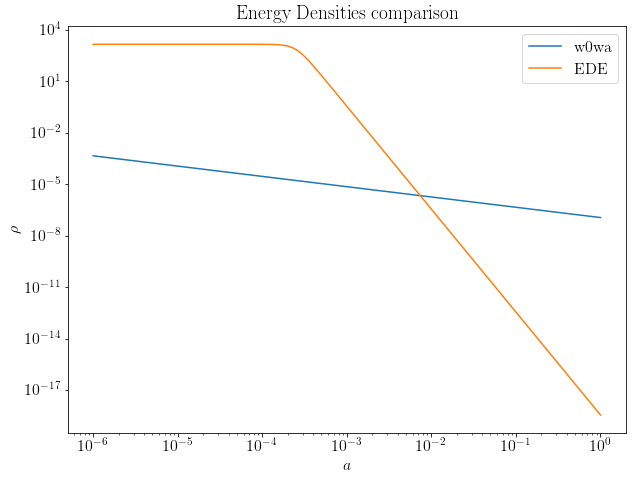

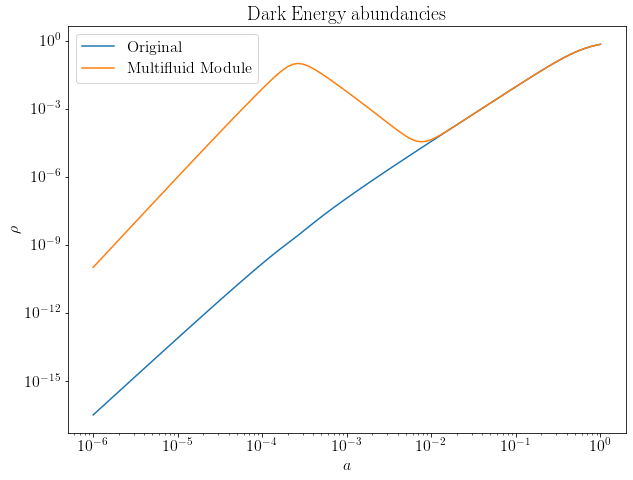

In [19]:
# Cls from CMB
plt.plot(ells[2:], cls[2:])
plt.plot(ells[2:], cls2[2:])
plt.title("CMB Temperature Power Spectra Comparison")
plt.legend([r"No EDE", r"EDE"])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.xscale('log')
plt.show()
# Cls diff
plt.plot(ells[2:], abs(cls[2:] - cls2[2:]))
plt.title("CMB Temperature Power Spectra Difference")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\Delta C_\ell$")
plt.yscale('log')
plt.xscale('log')
plt.show()
# DE densities
plt.plot(scales, rho_de/scales**4)
# plt.plot(scales, rho_de2/scales**4)
plt.plot(scales, rho_ede2/scales**4)
plt.title("Energy Densities comparison")
plt.legend([r"w0wa", r"EDE"])
plt.xlabel(r"$a$")
plt.ylabel(r"$\rho$")
plt.xscale('log')
plt.yscale('log')
plt.show()
# DE abundancies
plt.plot(scales, omegaw1)
plt.plot(scales, omegaw2 + omegaede)
plt.title("Dark Energy abundancies")
plt.legend([r"Original", r"Multifluid Module"])
plt.xlabel(r"$a$")
plt.ylabel(r"$\rho$")
plt.xscale('log')
plt.yscale('log')
plt.show()

From all of the comparisons, this one was the "worst": for low multipoles, we get a difference of order 1. Of course, the relative difference $\Delta C_\ell / C_\ell$ is of order $10^{-3}$, which is fine, but still is greater than the other comparisons. Just for safety, I compare the original implementation of fluid and PPF.

In [18]:
w = -0.8
scales = np.logspace(-6, 0, 100)
redshifts = np.logspace(0, 5, 500)
cosmology1 = camb.set_params(# Background
                                H0 = 70, ombh2=0.02238280, omch2=0.1201075, TCMB = 2.7255,
                                dark_energy_model = 'fluid', w = w,
                                # Neutrinos
                                omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                                nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                                # Initial Power Spectrum
                                As = 2.100549e-09, ns = 0.9660499, 
                                YHe = 0.246, WantTransfer=True)
cosmology2 = camb.set_params(# Background
                                H0 = 70, ombh2=0.02238280, omch2=0.1201075, TCMB = 2.7255,
                                dark_energy_model = 'ppf', w = w,
                                # Neutrinos
                                omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                                nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                                # Initial Power Spectrum
                                As = 2.100549e-09, ns = 0.9660499, 
                                YHe = 0.246, WantTransfer=True)
results1 = camb.get_results(cosmology1)
results2 = camb.get_results(cosmology2)
rho_de = results1.get_background_densities(scales)['de']
rho_de2 = results2.get_background_densities(scales)['de']
rho_ede2 = results2.get_background_densities(scales)['de2']
_, wde1= results1.get_dark_energy_rho_w(scales)
_, wde2= results2.get_dark_energy_rho_w(scales)
cls = results1.get_unlensed_scalar_cls(CMB_unit = 'muK')[:,0]
cls2 = results2.get_unlensed_scalar_cls(CMB_unit = 'muK')[:,0]
omegaw1 = results1.get_Omega('de', z = 1/scales - 1)
omegaw2 = results2.get_Omega('de', z = 1/scales - 1)
omegaede = results2.get_Omega('de2', z = 1/scales - 1)

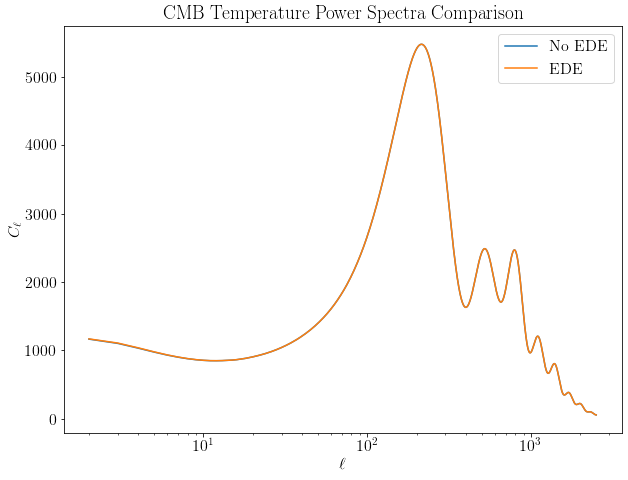

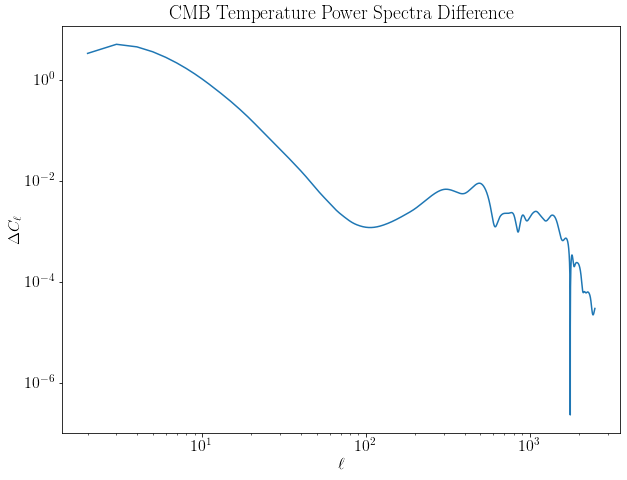

In [19]:
# Cls from CMB
plt.plot(ells[2:], cls[2:])
plt.plot(ells[2:], cls2[2:])
plt.title("CMB Temperature Power Spectra Comparison")
plt.legend([r"No EDE", r"EDE"])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.xscale('log')
plt.show()
# Cls diff
plt.plot(ells[2:], abs(cls[2:] - cls2[2:]))
plt.title("CMB Temperature Power Spectra Difference")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\Delta C_\ell$")
plt.yscale('log')
plt.xscale('log')
plt.show()

OK, this "big" low-l difference is due to the PPF x Fluid formalism.

Comparing original CAMB with Multifluid: power spectra

## Testing Binned w in Multifluid

In [1]:
import camb
from camb import model
import numpy as np
import matplotlib.pyplot as plt
import sys

In [4]:
# Params
h_ref = 0.75
Omegab_ref = 0.049
Omegam_ref = 0.159
Omegac_ref = Omegam_ref - Omegab_ref
As10to9_ref = 2.1
As_ref = 2.1*10**-9
ns_ref = 0.96
wde_ref = -1
zc = 5000
fde_zc = 0.00
tau = 0.07
w0 = -1.05
w1 = -1.5
w2 = -3
w3 = -1.2
w4 = -0.8
w5 = -1

In [5]:
cosmology = camb.set_params(# Background
                            H0 = 100*h_ref, ombh2=Omegab_ref*h_ref**2, omch2=Omegac_ref*h_ref**2,
                            TCMB = 2.7255,
                            # Dark Energy
                            dark_energy_model='MultiFluidDE', num_of_components=1,
                            models=[4,1,0,0], w0 = w0, w1 = w1, w2 = w2, w3 = w3, w4 = w4, w5 = w5,
                            zc = 3000, fde_zc = 0.05, wn=0.5,
                            # Neutrinos
                            nnu=3.046, omnuh2 = 0,
                            # Initial Power Spectrum
                            As = As_ref, ns = ns_ref, tau = tau,
                            YHe = 0.246, NonLinear=True, WantTransfer=True, max_l = 10000, halofit_version='casarini')
#print(cosmology.DarkEnergy)
results = camb.get_results(cosmology)
pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[2]
#print(results.Params.DarkEnergy)
cls = results.get_unlensed_scalar_cls(CMB_unit = 'muK')[:,0]
ells = [i for i in range(len(cls))]

In [82]:
cosmology = camb.set_params(# Background
                            H0 = 100*h_ref, ombh2=Omegab_ref*h_ref**2, omch2=Omegac_ref*h_ref**2,
                            TCMB = 2.7255,
                            # Dark Energy
                            dark_energy_model='fluid', w=-1,
                            # Neutrinos
                            nnu=3.046, omnuh2 = 0,
                            # Initial Power Spectrum
                            As = As_ref, ns = ns_ref, tau = tau,
                            YHe = 0.246, NonLinear=False, WantTransfer=True, max_l = 10000)
#print(cosmology.DarkEnergy)
results = camb.get_results(cosmology)
ks = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[0]
pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[2]
#print(results.Params.DarkEnergy)
cls = results.get_unlensed_scalar_cls(CMB_unit = 'muK')[:,0]
ells = [i for i in range(len(cls))]

ImportError: cannot import name 'calc_transfers' from 'camb.results' (/home/joaov/cosmo/CAMB/CAMBMultiFluidDE/camb/results.py)

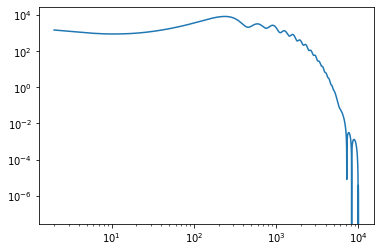

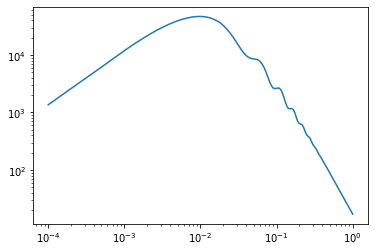

In [89]:
plt.loglog(ells[2:], abs(cls[2:]))
plt.show()
plt.loglog(ks, pk[0])

In [3]:
tentativa = (10*w0 + 2*w1 + 1*w2)/13
print(tentativa)

-1.1076923076923078


In [9]:
scales = np.linspace(0.2, 1, 200)
rhos, wde = results.get_dark_energy_rho_w(scales)
redshifts = 1/scales - 1

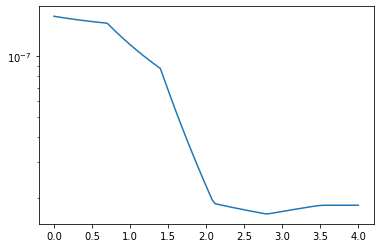

In [10]:
plt.semilogy(redshifts, rhos[:,0])

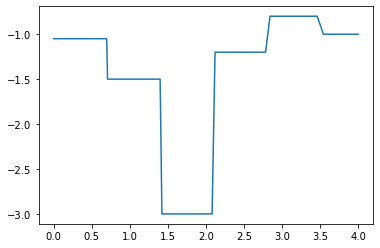

In [11]:
plt.plot(redshifts, wde[:,0])

## Testing Casarini implementation

In [5]:
import camb
from camb import model
import numpy as np
import matplotlib.pyplot as plt
import sys

In [16]:
# Params
h_ref = 0.75
Omegab_ref = 0.049
Omegam_ref = 0.159
Omegac_ref = Omegam_ref - Omegab_ref
As10to9_ref = 2.1
As_ref = 2.1*10**-9
ns_ref = 0.96
wde_ref = -1
zc = 5000
fde_zc = 0.00
tau = 0.07
w0 = -0.5
w1 = -1.2
w2 = -2

In [17]:
cosmology = camb.set_params(# Background
                            H0 = 100*h_ref, ombh2=Omegab_ref*h_ref**2, omch2=Omegac_ref*h_ref**2,
                            TCMB = 2.7255,
                            # Dark Energy
                            dark_energy_model='MultiFluidDE', num_of_components=1,
                            models=[3,1,0,0], w0 = w0, w1 = w1, w2 = w2, w3 = -1,
                            zc = 3000, fde_zc = 0.05, wn=0.5,
                            # Neutrinos
                            nnu=3.046, omnuh2 = 0,
                            # Initial Power Spectrum
                            As = As_ref, ns = ns_ref, tau = tau,
                            YHe = 0.246, NonLinear=True, WantTransfer=True, max_l = 10000, halofit_version='casarini')
results = camb.get_results(cosmology)
pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[2]

 [casarini] At z =    0.00000000      equivalent w_const = -0.778934479    


Let's see if this w_const really has the same distance to the last scattering surface

In [18]:
results.get_derived_params()

{'age': 13.581212355892161,
 'zstar': 1079.8403857702162,
 'rstar': 157.84005388828754,
 'thetastar': 1.0085395639526773,
 'DAstar': 15.650358154486215,
 'zdrag': 1066.8507233867797,
 'rdrag': 159.14622478973914,
 'kd': 0.13067634977911366,
 'thetad': 0.15361322157872503,
 'zeq': 2136.9093767603863,
 'keq': 0.006523020847775388,
 'thetaeq': 1.1476151185016201,
 'thetarseq': 0.6109161715172292}

In [19]:
cosmology = camb.set_params(# Background
                            H0 = 100*h_ref, ombh2=Omegab_ref*h_ref**2, omch2=Omegac_ref*h_ref**2,
                            TCMB = 2.7255,
                            # Dark Energy
                            dark_energy_model='MultiFluidDE', num_of_components=1,
                            models=[1,1,0,0], w0 = -0.778934479,
                            zc = 3000, fde_zc = 0.05, wn=0.5,
                            # Neutrinos
                            nnu=3.046, omnuh2 = 0,
                            # Initial Power Spectrum
                            As = As_ref, ns = ns_ref, tau = tau,
                            YHe = 0.246, NonLinear=True, WantTransfer=True, max_l = 10000, halofit_version='casarini')
results = camb.get_results(cosmology)
pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[2]

 [casarini] At z =    0.00000000      equivalent w_const = -0.778934062    


In [20]:
results.get_derived_params()

{'age': 13.946380520648047,
 'zstar': 1079.840425662099,
 'rstar': 157.84004521952065,
 'thetastar': 1.0085394118024764,
 'DAstar': 15.65035965599268,
 'zdrag': 1066.8507298607149,
 'rdrag': 159.14621925233106,
 'kd': 0.13067638548794916,
 'thetad': 0.15361316486437745,
 'zeq': 2136.9093767603863,
 'keq': 0.00652302098966984,
 'thetaeq': 1.1476150026090488,
 'thetarseq': 0.6109161099807464}